In [1]:
import Modules.SQcircuit_extensions as sq_ext
import Modules.figures as figs
import SQcircuit as sq
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload 
import qutip as qt
from scipy.optimize import curve_fit, minimize

# %matplotlib ipympl
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Palatino"],
# })
plt.rcParams['text.usetex'] = False
reload(sq_ext)
reload(sq)
reload(figs)
np.set_printoptions(linewidth=300, formatter={'float': '{:.12f}'.format})
# np.set_printoptions(linewidth=200, formatter={'float': '{:.1e}'.format})

<Figure size 640x480 with 0 Axes>

In [2]:
nH   = 1e-9
fF   = 1e-15
GHz  = 1e9
h    = 6.626e-34
e0   = 1.602e-19
Φ_0  = h/(2*e0)

## Fluxonium qutrit vs $\phi_{ext}$

In [3]:
C, CJ, Csh, Lq, Lr, Δ, EJ = sq_ext.get_experimental_parameters('qubit_1', return_effective=False)
C_F_eff, C_R_eff = sq_ext.C_CJ_Csh_to_CF_CR_eff(C, CJ, Csh)
L_F_eff, L_R_eff, L_C_eff = sq_ext.Lq_Lr_to_LF_LR_LC_eff(Lq, Lr, Δ)

In [4]:
nmax_f=20

fluxonium = sq_ext.sq_fluxonium(EJ=EJ, C_F_eff=C_F_eff, L_F_eff =L_F_eff, Δ=Δ, φ_ext=0.5, nmax_f=nmax_f)
H_0  = fluxonium.hamiltonian()
E_0, ψ_0 = sq_ext.diag(H_0, 3, solver='numpy', qObj=True, remove_ground=True)

In [5]:
φ_ext_values                = np.linspace(0.5, 0.65, 100)
E_vs_φ_ext                  = np.zeros([len(φ_ext_values), 3])
H_eff_SWT_decomp_vs_φ_ext   = np.zeros([len(φ_ext_values), 9])
ω_qo_vs_φ_ext               = np.zeros([len(φ_ext_values), 3])

In [6]:
reload(sq_ext)

loop = fluxonium.loops[0]
for i, φ_ext  in enumerate(φ_ext_values):
    loop.set_flux(φ_ext)
    H = fluxonium.hamiltonian()
    E_vs_φ_ext[i], ψ = sq_ext.diag(H, 3, solver='numpy', qObj=True, remove_ground=True)
    H_eff_SWT = sq_ext.H_eff_SWT_large(ψ_0, ψ, E_vs_φ_ext[i], remove_I=True)
    H_eff_SWT_decomp_vs_φ_ext[i]  = sq_ext.decomposition_in_pauli_3x3(H_eff_SWT, print_pretty=False)
    

labels_H_eff_SWT_decomp = sq_ext.decomposition_in_pauli_3x3(H_eff_SWT, print_pretty=False, return_labels=True, test_decomposition=True)[1]   

C:\Users\gabri\AppData\Local\Temp\ipykernel_52560\3613405795.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  H_eff_SWT_decomp_vs_φ_ext[i]  = sq_ext.decomposition_in_pauli_3x3(H_eff_SWT, print_pretty=False)



Original eigenvalues:
[0.000000000000 5.897810000000 11.393960000000]
Reconstructed eigenvalues:
[0.000000000000 5.897810000000 11.393960000000]
Spectra match (within tolerance).


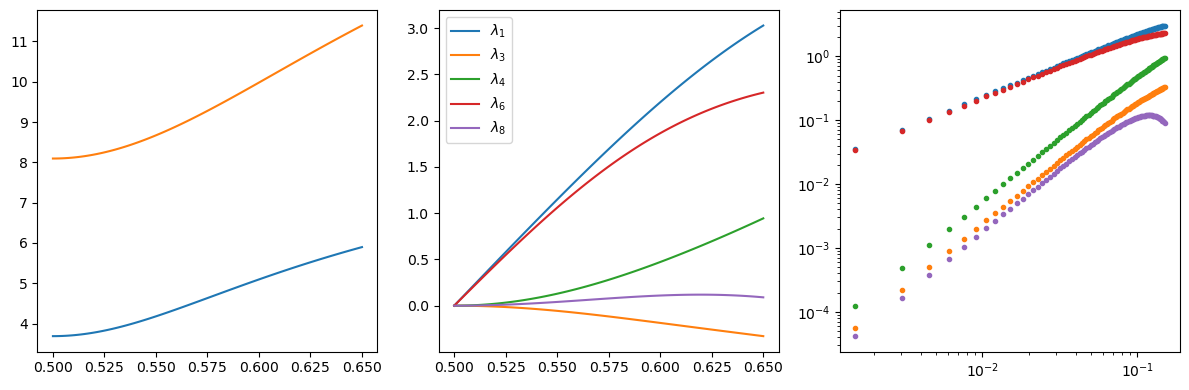

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=[12,4])

ax1.plot(φ_ext_values, E_vs_φ_ext[:,1:])
for i in range(1, 9):
    if np.any(np.abs(H_eff_SWT_decomp_vs_φ_ext[:,i])>1e-5):
        ax2.plot(φ_ext_values, H_eff_SWT_decomp_vs_φ_ext[:,i]-H_eff_SWT_decomp_vs_φ_ext[0,i], label=labels_H_eff_SWT_decomp[i])
        ax3.plot(φ_ext_values-0.5, np.abs(H_eff_SWT_decomp_vs_φ_ext[:,i]-H_eff_SWT_decomp_vs_φ_ext[0,i]),'.', label=labels_H_eff_SWT_decomp[i])
# ax2.plot(φ_ext_values, np.abs(H_eff_SWT_decomp_vs_φ_ext[:,1]-H_eff_SWT_decomp_vs_φ_ext[:,6]),'.k' )
ax2.legend()
ax3.set_yscale('log')
ax3.set_xscale('log')
fig.tight_layout()

In [59]:
i=0
ωq_01 = E_vs_φ_ext[0][1]
ωq_02 = E_vs_φ_ext[0][2]
g_λ = H_eff_SWT_decomp_vs_φ_ext[i]
g_λ1, g_λ3, g_λ4, g_λ6, g_λ8 =[g_λ[1], g_λ[3]+ωq_01/2, g_λ[4], g_λ[6], g_λ[8]-(ωq_01 - 2 * ωq_02) / 2 / np.sqrt(3) ]
H = sq_ext.H_fluxonium_qutrit(ωq_01, ωq_02, g_λ1, g_λ3, g_λ4, g_λ6, g_λ8)
E_vs_φ_ext[i], sq_ext.diag(H,3, solver='numpy', out=None, remove_ground=True)[0]